In [15]:
import numpy as np
from tabulate import tabulate
import random
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import pandas as pd
from statistics import mode 
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.metrics import homogeneity_score, f1_score

In [16]:
def get_clusters(k,X,y,initial,dist):
    kmeans = Kmeans(X,y,distance=dist)
    kmeans.fit(k,initial)
    return [kmeans.clusters,kmeans.centers]            

In [17]:
def eucledian(x,y):     
    return np.sqrt(np.array(np.sum((x-y)**2,1), dtype=np.float64))

In [18]:
def manhattan(x,y):
    return np.sum(np.abs(np.subtract(x,y)),1)

In [19]:
#implement Kmeans from scratch
class Kmeans:
    def __init__(self,X_train,y_train,distance="eucledian"):
        self.X_train = X_train
        self.y_train = y_train
        self.distance = distance
        self.clusters = None
        self.centers = None
    
    def forgy(self,data,k):
        return data[np.random.choice(range(data.shape[0]), replace = False,     size = k), :]
    
    def randomPartition(self,X, k):
        res = []   
        for j in range(len(X)): 
            res.append(random.randint(0, k-1)) 
        c = {}
        for i in range(0,k):
            c[i] = []
        for i in range(len(X)):
            c[res[i]].append(X[i])
        centers = []
        for p in c:
            centers.append(np.sum(c[p],axis=0)/len(c[p]))            
        return np.array(centers)

    def fit(self,k,initial,epochs=100):
        no_of_clusters = len(initial)
        clusters = {}
        for i in range(0,epochs):
            temp = initial
            for i in range(0,no_of_clusters):
                clusters[i] = []
            for i in range(len(self.X_train)):
                if(self.distance=="eucledian"):
                    distances = eucledian(initial,self.X_train[i])
                else:
                    distances = (manhattan(initial,self.X_train[i]))
                clusters[np.argmin(distances)].append([self.X_train[i],self.y_train[i]])          
                    
            for c in clusters.keys():
                x = (np.array(clusters[c]))
                temp1 = x[:,0]
                initial[c] = np.sum(temp1,axis=0)/len(clusters[c])
                  
        self.assign_lables(initial,clusters)
        
    def assign_lables(self,initial,clusters):
        temp = {}
        temp_centers= {}
        temp_initial = []
        for c in clusters.keys():
            l = np.array(clusters[c])
#             print(l.shape)
            l = l[:,1]
            val = mode(l)
            temp[val] = clusters[c]
            temp_centers[val] = initial[c]
        self.clusters = temp
        initial = []
        for c in temp_centers.keys():
            initial.append(temp_centers[c])
        self.centers = initial
        
    
    def predict(self,test):
        labels = []
        l = list(self.clusters.keys())
        for t in range(0,len(test)):
            if self.distance == "eucledian":
                d = eucledian(self.centers,test[t])
            else:
                d = manhattan(self.centers,test[t])
            labels.append(l[np.argmin(d)])
            
        return np.array(labels)

In [20]:
#implement elbow method from scratch
def elbow(x,y,start,end,dist="eucledian",initialization="randomPartiton"):
    ks = []
    WSS = []
    for k in range(start,end):
        print(k)
        ks.append(k)          
        kmeans = Kmeans(x,y,distance=dist)
        if(initialization=="KmeansPlusPlus"):
            kmeansp = Kmeansplusplus(x,y)
            initials = kmeansp.kmeanspp(x,k,dist)
        elif(initialization=="forgy"):
            initials = kmeans.forgy(x,k)
        else:
            initials = kmeans.randomPartition(x,k)
        kmeans.fit(k,initials)
        initials = kmeans.centers
        sum = 0
        for i in range(len(x)):
            if(dist == "eucledian"):
                distances = eucledian(initials,x[i])
            else:
                distances = (manhattan(initials,x[i]))
            sum+=distances[np.argmin(distances)]
        WSS.append(sum)

    return [ks,WSS]

In [21]:
#implement silhouette method from scratch
def silhouette(X,y,start,end,dist="eucledian",initialization="forgy"):
    ks = []
    s = []
    for k in range(start,end):
        print(k)
        ks.append(k)
        a = 0
        b = 0
        kmeans = Kmeans(X,y)
        if(initialization=="forgy"):
            centers = kmeans.forgy(X,k)
        elif(initialization=="KmeansPlusPlus"):
            kmeansp = Kmeansplusplus(X,y)
            centers = kmeansp.kmeanspp(X,k,dist)
        else:
            centers = kmeans.randomPartition(X,k)
        cluster,initial = get_clusters(k,X,y,centers,dist)
        for c in cluster.keys():
            cluster[c] = np.array(cluster[c])
            
        Si = []
        for c in cluster.keys():
            for j in range(len(cluster[c])):
                a = None
                b = None
                if(dist == "eucledian"):
                    filtered_data = np.delete(cluster[c], j, axis=0)
                    
                    
                    size = len(filtered_data[:,0][0])
                    temp = np.hstack(filtered_data[:,0])
                    temp = temp.reshape(len(temp)//size,size)
                                        
                    a = np.mean(eucledian(temp,cluster[c][j][0]))
                    
                    other_centers = np.delete(centers, c, axis=0)
                    distances = eucledian(other_centers, centers[c])
                    nearest_cluster = cluster[np.argmin(distances)]
                    
                    size = len(nearest_cluster[:,0][0])
                    temp = np.hstack(nearest_cluster[:,0])
                    temp = temp.reshape(len(temp)//size,size)
                    
                    b = np.mean(eucledian(temp,cluster[c][j][0]))
                    
                    Si.append((b-a)/max(b,a))
                else:
                    filtered_data = np.delete(cluster[c], j, axis=0)
                    
                    
                    size = len(filtered_data[:,0][0])
                    temp = np.hstack(filtered_data[:,0])
                    temp = temp.reshape(len(temp)//size,size)                   
                    
                    
                    a = np.mean(manhattan(temp,cluster[c][j][0]))
                    
                    other_centers = np.delete(centers, c, axis=0)
                    distances = manhattan(other_centers, centers[c])
                    nearest_cluster = cluster[np.argmin(distances)]
                    
                    size = len(nearest_cluster[:,0][0])
                    temp = np.hstack(nearest_cluster[:,0])
                    temp = temp.reshape(len(temp)//size,size)
                    
                    b = np.mean(manhattan(temp,cluster[c][j][0]))                    
                    Si.append((b-a)/max(b,a))
                
        Si = np.array(Si)
        s.append(np.mean(Si))   

    return [ks,s]


In [22]:
from keras.datasets import fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

In [23]:
X = np.concatenate((trainX,testX), axis=0)
y = np.concatenate((trainy,testy), axis=0)

## Loading the dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9, random_state = 42)

In [ ]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

r,c,p = X_train.shape
X_train = X_train.reshape(r,c*p)
r,c,p = X_test.shape
X_test = X_test.reshape(r,c*p)

#### Do we need to normalize the data?

Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information. 


But here the data consists of images whose value are already in the range of 0-255 for all the pixels. 
So we don't need to normalize the data

##  Finding optimal K value uisng elbow and silhoutte method

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
%matplotlib inline


k_s, S = silhouette(X_train,y_train,2,15,dist="eucledian")
k_s1, S1 = silhouette(X_train,y_train,2,15,dist="manhattan")


ks, WSS = elbow(X_train,y_train,2,15)
ks1, WSS1 = elbow(X_train,y_train,2,15,dist="manhattan")

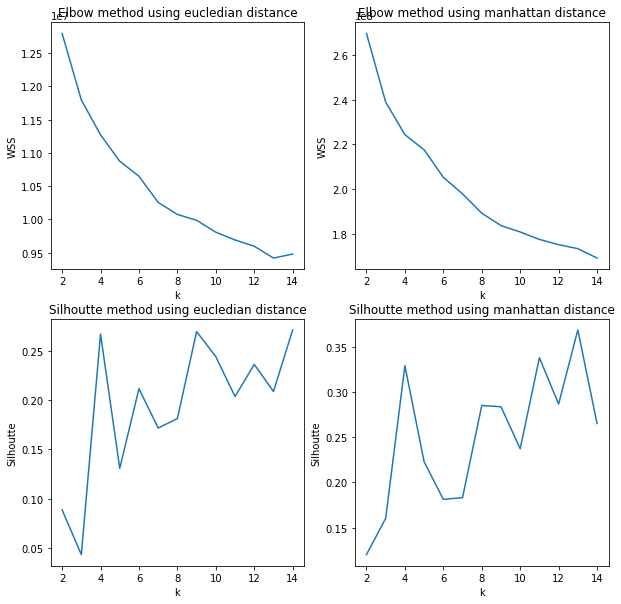

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(ks,WSS)
ax2.plot(ks1,WSS1)
ax3.plot(k_s,S)
ax4.plot(k_s1,S1)

fig.set_figheight(10)
fig.set_figwidth(10)

ax1.set(xlabel="k",ylabel="WSS")
ax2.set(xlabel="k",ylabel="WSS")
ax3.set(xlabel="k",ylabel="Silhoutte")
ax4.set(xlabel="k",ylabel="Silhoutte")

ax1.title.set_text('Elbow method using eucledian distance')
ax2.title.set_text('Elbow method using manhattan distance')
ax3.title.set_text('Silhoutte method using eucledian distance')
ax4.title.set_text('Silhoutte method using manhattan distance')
plt.show()

__Observation__:

- From the first graph the elbow shape is there at k=(6,10,11)
- From the second graph the elbow shape is tehre at k=(9,11)
- From the third graph the maximum score is at k = 13
- From teh fourth graph the maximum score is at k = 12


Considering al the above values of it would be optimal to consider k as 11 as it is in between all the values obtained for the value of k

In [ ]:
k = 11

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

r,c,p = X_train.shape
X_train = X_train.reshape(r,c*p)
r,c,p = X_test.shape
X_test = X_test.reshape(r,c*p)

### 3 Defining initial cluster centers using Forgy and Random pratition and
### 4 Experimenting with different distance measures

__Initialize with forgy and use eucledian distance__

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

kmeans = Kmeans(X_train,y_train,distance="eucledian")
forgy_centerss = kmeans.forgy(X_train,k)
kmeans.fit(k,forgy_centerss)
kmeans_forgy_eucledian_lables = kmeans.predict(X_test)
kmeans_forgy_eucledian_prediction = homogeneity_score(y_test, kmeans_forgy_eucledian_lables)
kmeans_forgy_eucledian_accuracy = accuracy_score(y_test,kmeans_forgy_eucledian_lables)
print("testing accuracy: ",kmeans_forgy_eucledian_accuracy)
print("f1 score: ",f1_score(y_test, kmeans_forgy_eucledian_lables, zero_division=1, average='micro'))

kmeans_forgy_eculedian_training_lables = kmeans.predict(X_train)
kmeans_forgy_eucledian_training_prediction = homogeneity_score(y_train, kmeans_forgy_eculedian_training_lables)
kmeans_forgy_eucledian_training_accuracy = accuracy_score(y_train,kmeans_forgy_eculedian_training_lables)
print("training accuracy: ",kmeans_forgy_eucledian_training_accuracy)

testing accuracy:  0.5877619047619047
f1 score:  0.5877619047619047
training accuracy:  0.580530612244898


__Initialize with forgy and use manhattan distance__

In [ ]:
kmeans = Kmeans(X_train,y_train,distance="manhattan")
forgy_centerss = kmeans.forgy(X_train,k)
kmeans.fit(k,forgy_centerss)
kmeans_forgy_manhattan_lables = kmeans.predict(X_test)
kmeans_forgy_manhattan_prediction = homogeneity_score(y_test, kmeans_forgy_manhattan_lables)
kmeans_forgy_manhattan_accuracy = accuracy_score(y_test,kmeans_forgy_manhattan_lables)
print("testing accuracy: ",kmeans_forgy_manhattan_accuracy)
print("f1 score: ",f1_score(y_test, kmeans_forgy_manhattan_lables, zero_division=1, average='micro'))


kmeans_forgy_manhattan_training_lables = kmeans.predict(X_train)
kmeans_forgy_manhattan_training_prediction = homogeneity_score(y_train, kmeans_forgy_manhattan_training_lables)
kmeans_forgy_manhattan_training_accuracy = accuracy_score(y_train,kmeans_forgy_eculedian_training_lables)
print("training accuracy: ",kmeans_forgy_manhattan_training_accuracy)

testing accuracy:  0.4767619047619048
f1 score:  0.4767619047619048
training accuracy:  0.580530612244898


__Initialize with random partition and use eucledian distance__

In [ ]:
kmeans = Kmeans(X_train,y_train,distance="eucledian")
forgy_centerss = kmeans.randomPartition(X_train,k)
kmeans.fit(k,forgy_centerss)
kmeans_randomPartition_eucledian_lables = kmeans.predict(X_test)
kmeans_randomPartition_eucledian_prediction = homogeneity_score(y_test, kmeans_randomPartition_eucledian_lables)
kmeans_randomPartition_eucledian_accuracy = accuracy_score(y_test,kmeans_randomPartition_eucledian_lables)
print("testing accuracy: ",kmeans_randomPartition_eucledian_accuracy)
print("f1 score: ",f1_score(y_test, kmeans_randomPartition_eucledian_lables, zero_division=1, average='micro'))



kmeans_randomPartition_eculedian_training_lables = kmeans.predict(X_train)
kmeans_randomPartition_eucledian_training_prediction = homogeneity_score(y_train, kmeans_randomPartition_eculedian_training_lables)
kmeans_randomPartition_eucledian_training_accuracy = accuracy_score(y_train,kmeans_randomPartition_eculedian_training_lables)
print("training accuracy: ",kmeans_randomPartition_eucledian_training_accuracy)

testing accuracy:  0.6046190476190476
f1 score:  0.6046190476190476
training accuracy:  0.5997755102040816


__Initialize with random partition and use manhattan distance__

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


kmeans = Kmeans(X_train,y_train,distance="manhattan")
forgy_centerss = kmeans.randomPartition(X_train,k)
kmeans.fit(k,forgy_centerss)
kmeans_randomPartition_manhattan_lables = kmeans.predict(X_test)
kmeans_randomPartition_manhattan_prediction = homogeneity_score(y_test, kmeans_randomPartition_manhattan_lables)
kmeans_randomPartition_manhattan_accuracy = accuracy_score(y_test,kmeans_randomPartition_manhattan_lables)
print("testing accuracy: ",kmeans_randomPartition_manhattan_accuracy)
print("f1 score: ",f1_score(y_test, kmeans_randomPartition_manhattan_lables, zero_division=1, average='micro'))


kmeans_randomPartition_manhattan_training_lables = kmeans.predict(X_train)
kmeans_randomPartition_manhattan_training_prediction = homogeneity_score(y_train, kmeans_randomPartition_manhattan_training_lables)
kmeans_randomPartition_manhattan_training_accuracy = accuracy_score(y_train,kmeans_randomPartition_manhattan_training_lables)
print("training accuracy: ",kmeans_randomPartition_manhattan_training_accuracy)

testing accuracy:  0.4700952380952381
f1 score:  0.4700952380952381
training accuracy:  0.46244897959183673


In [ ]:
print("for testing homogenity score\n\n")

tabuler_data = [["Forgy",kmeans_forgy_eucledian_prediction,kmeans_forgy_manhattan_prediction],["Random partition",kmeans_randomPartition_eucledian_prediction,kmeans_randomPartition_manhattan_prediction]]
print(tabulate(tabuler_data, headers=['Homogenity_score','Eucledian','Manhattan'], tablefmt='orgtbl'))

for testing homogenity score


| Homogenity_score   |   Eucledian |   Manhattan |
|--------------------+-------------+-------------|
| Forgy              |    0.500208 |    0.451207 |
| Random partition   |    0.506479 |    0.437414 |


In [ ]:
print("For training homogenity score\n\n")

tabuler_data = [["Forgy",kmeans_forgy_eucledian_training_prediction,kmeans_forgy_manhattan_training_prediction],["Random partition",kmeans_randomPartition_eucledian_training_prediction,kmeans_randomPartition_manhattan_training_prediction]]
print(tabulate(tabuler_data, headers=['Homogenity_score','Eucledian','Manhattan'], tablefmt='orgtbl'))

For training homogenity score


| Homogenity_score   |   Eucledian |   Manhattan |
|--------------------+-------------+-------------|
| Forgy              |    0.494509 |    0.444702 |
| Random partition   |    0.505412 |    0.429405 |


__Conclusion__:

Got more aacuracy for randompartiton ans eculedian distance

### Compare with inbuilt model

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k,n_init=100)
kmeans.fit(X_train)
l = kmeans.predict(X_test)
inbuilt_mode_score = homogeneity_score(y_test, l)

print("Inbuilt model homogenity score: "+str(inbuilt_mode_score))

Inbuilt model homogenity score: 0.5117818544600072


### Visualize the dataset to depict the clusters formed

In [31]:
def fun_tsne(model, X, y,l):
    y = np.array(y)
    model = TSNE(n_components=2, random_state=0)
    tsne_data = model.fit_transform(X[:l])
    tsne_data = np.vstack((tsne_data.T, y[:l])).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1','Dim_2',"label_"))
    sn.FacetGrid(tsne_df, hue="label_",height=4).map(plt.scatter, 'Dim_1','Dim_2')
    plt.show()

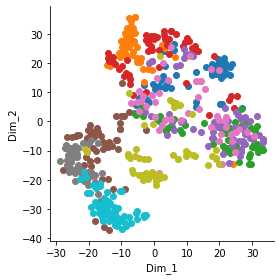

In [ ]:
fun_tsne(kmeans,X_test,y_test,500)

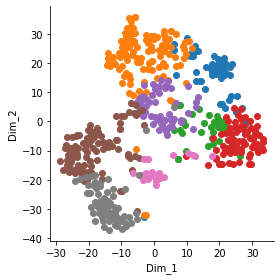

In [ ]:
fun_tsne(kmeans,X_test,kmeans_randomPartition_manhattan_lables,500)

__Observation__ :

- From the above we can observe that the outline of the line graph is same
- The clusters are formed properly according to the value of k
- As the value of k is more in original data we can see more clusters in the first figure 

In [24]:
#implement Kmeans++ from scratch
class Kmeansplusplus:
    
    def __init__(self,X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.clusters = None
        self.centers = None
        self.dist = None

    def kmeanspp(self,X,k,dist="eucledian"):
        centers = []
        ind = np.random.choice(range(X.shape[0]), replace = False,     size = 1)
        centers = np.array(X[ind])
        
        filtered_data = np.delete(X, ind, axis=0)
        while len(centers) < k:
            res1 =  (filtered_data[:, np.newaxis] - centers).reshape(-1, filtered_data.shape[1])
            if(dist=="eucledian"):
                res1 = np.sqrt(np.array(np.sum((res1)**2,1), dtype=np.float64))
            else:
                res1 = np.sum(np.abs(res1),axis=1)

            ind = np.argmax(res1) % len(filtered_data)
            centers = np.vstack((centers,[filtered_data[ind]]))
            filtered_data = np.delete(filtered_data, ind, axis=0)
            
        return centers
    
    def fit(self,k,initial,epochs=100,dist="eucledian"):
        self.dist = dist
        no_of_clusters = len(initial)
        clusters = {}
        for i in range(0,epochs):
            temp = initial
            for i in range(0,no_of_clusters):
                clusters[i] = []
            for i in range(len(self.X_train)):
                if(dist == "eucledian"):
                    distances = eucledian(initial,self.X_train[i])
                else:
                    distances = (manhattan(initial,self.X_train[i]))
                clusters[np.argmin(distances)].append([self.X_train[i],self.y_train[i]])          
                    
            for c in clusters.keys():
                x = (np.array(clusters[c]))
                temp1 = x[:,0]
                initial[c] = np.sum(temp1,axis=0)/len(clusters[c])
               
            self.assign_lables(initial,clusters)
        
    def assign_lables(self,initial,clusters):
        temp = {}
        temp_centers= {}
        temp_initial = []
        for c in clusters.keys():
            l = np.array(clusters[c])
            l = l[:,1]
            val = mode(l)
            temp[val] = clusters[c]
            temp_centers[val] = initial[c]
        self.clusters = temp
        initial = []
        for c in temp_centers.keys():
            initial.append(temp_centers[c])
        self.centers = initial
    
    def predict(self,test):
        labels = []
        for t in range(0,len(test)):
            if(self.dist == "eucledian"):
                d = eucledian(self.centers,test[t])
            else:
                d = manhattan(self.centers,test[t])
            labels.append(np.argmin(d))
            
        return np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9, random_state = 42)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

r,c,p = X_train.shape
X_train = X_train.reshape(r,c*p)
r,c,p = X_test.shape
X_test = X_test.reshape(r,c*p)

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

ks, WSS = elbow(X_train,y_train,2,15,initialization="KmeansPlusPlus")
ks1, WSS1 = elbow(X_train,y_train,2,15,dist="manhattan",initialization="KmeansPlusPlus")

k_s, S = silhouette(X_train,y_train,2,15,dist="eucledian",initialization="KmeansPlusPlus")
k_s1, S1 = silhouette(X_train,y_train,2,15,dist="manhattan",initialization="KmeansPlusPlus")

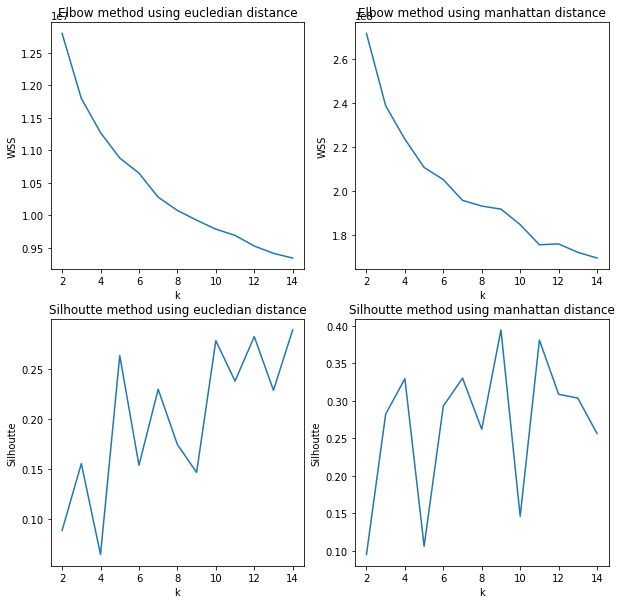

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(ks,WSS)
ax2.plot(ks1,WSS1)
ax3.plot(k_s,S)
ax4.plot(k_s1,S1)

fig.set_figheight(10)
fig.set_figwidth(10)

ax1.set(xlabel="k",ylabel="WSS")
ax2.set(xlabel="k",ylabel="WSS")
ax3.set(xlabel="k",ylabel="Silhoutte")
ax4.set(xlabel="k",ylabel="Silhoutte")

ax1.title.set_text('Elbow method using eucledian distance')
ax2.title.set_text('Elbow method using manhattan distance')
ax3.title.set_text('Silhoutte method using eucledian distance')
ax4.title.set_text('Silhoutte method using manhattan distance')
plt.show()

__Observation__ :

- From the first graph we can conclude that k = 7
- From the second graph we can conclude that k = 11
- From the thrid graph we can conclude k = 12
- From the fourth graph we can conclude that k = 9

Observing different values for k . We can take k as 11 as it is in the middle of all the k values

In [25]:
k = 11

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

r,c,p = X_train.shape
X_train = X_train.reshape(r,c*p)
r,c,p = X_test.shape
X_test = X_test.reshape(r,c*p)

In [ ]:
import warnings
warnings.filterwarnings('ignore')  

kmeans = Kmeansplusplus(X_train,y_train)
centers = kmeans.kmeanspp(X_train,k)
kmeans.fit(k,centers,dist="eucledian")
kmeans_kpp_eucledian_lables = kmeans.predict(X_test)
kmeans_kpp_eucledian_prediction = homogeneity_score(y_test, kmeans_kpp_eucledian_lables)
kmeans_kpp_eucledian_accuracy = accuracy_score(y_test,kmeans_kpp_eucledian_lables)
print("testing accuracy: ",kmeans_kpp_eucledian_accuracy)
print("f1 score: ",f1_score(y_test, kmeans_kpp_eucledian_lables, zero_division=1, average='micro'))

kmeans_kpp_eculedian_training_lables = kmeans.predict(X_train)
kmeans_kpp_eucledian_training_prediction = homogeneity_score(y_train, kmeans_kpp_eculedian_training_lables)
kmeans_kpp_eucledian_training_accuracy = accuracy_score(y_train,kmeans_kpp_eculedian_training_lables)
print("training accuracy: ",kmeans_kpp_eucledian_training_accuracy)

testing accuracy:  0.08704761904761905
f1 score:  0.08704761904761905
training accuracy:  0.08881632653061225


In [28]:
kmeans = Kmeansplusplus(X_train,y_train)
centers = kmeans.kmeanspp(X_train,k,dist="manhattan")
kmeans.fit(k,centers,dist="manhattan")
kmeans_kpp_manhattan_lables = kmeans.predict(X_test)
kmeans_kpp_manhattan_prediction = homogeneity_score(y_test, kmeans_kpp_manhattan_lables)
kmeans_kpp_manhattan_accuracy = accuracy_score(y_test,kmeans_kpp_manhattan_lables)
print("testing accuracy: ",kmeans_kpp_manhattan_accuracy)
print("f1 score: ",f1_score(y_test, kmeans_kpp_manhattan_lables, zero_division=1, average='micro'))

kmeans_kpp_manhattan_training_lables = kmeans.predict(X_train)
kmeans_kpp_manhattan_training_prediction = homogeneity_score(y_train, kmeans_kpp_manhattan_training_lables)
kmeans_kpp_manhattan_training_accuracy = accuracy_score(y_train,kmeans_kpp_manhattan_training_lables)
print("training accuracy: ",kmeans_kpp_manhattan_training_accuracy)

testing accuracy:  0.1718095238095238
f1 score:  0.1718095238095238
training accuracy:  0.17212244897959184


In [29]:
print("for testing accuracy\n\n")

tabuler_data = [["KmeansPlusPlus",kmeans_kpp_eucledian_prediction,kmeans_kpp_manhattan_prediction]]
print(tabulate(tabuler_data, headers=['Homogenity_score','Eucledian','Manhattan'], tablefmt='orgtbl'))

for testing accuracy


| Homogenity_score   |   Eucledian |   Manhattan |
|--------------------+-------------+-------------|
| KmeansPlusPlus     |    0.499448 |    0.443038 |


In [30]:
print("for training accuracy\n\n")

tabuler_data = [["KmeansPlusPlus",kmeans_kpp_eucledian_training_prediction,kmeans_kpp_manhattan_training_prediction]]
print(tabulate(tabuler_data, headers=['Homogenity_score','Eucledian','Manhattan'], tablefmt='orgtbl'))

for training accuracy


| Homogenity_score   |   Eucledian |   Manhattan |
|--------------------+-------------+-------------|
| KmeansPlusPlus     |    0.498774 |    0.445835 |


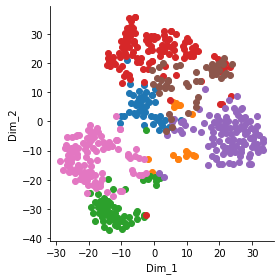

In [32]:
fun_tsne(kmeans,X_test,kmeans_kpp_manhattan_lables,500)

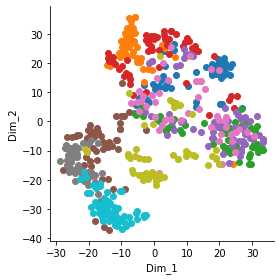

In [33]:
fun_tsne(kmeans,X_test,y_test,500)

__Observation__ :

- From the above we can observe that the outline of the line graph is same
- The clusters are formed properly according to the value of k
- As the value of k is more in original data we can see more clusters in the first figure 

# Part-2

In [37]:
df = pd.read_csv('/content/data.csv')
# !pwd

/content


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3625 entries, 0 to 3624
Columns: 193 entries, [1.0866963863372803 to  Ankle Boot
dtypes: float64(190), object(3)
memory usage: 5.3+ MB


In [42]:
data = df.to_numpy()

In [47]:
temp = {" Ankle Boot":1," Bag":2," Coat":3," Dress":4," Pullover":5," Sandal":6," Shirt":7," Sneaker":8," T-Shirt":9," Trouser":0}
data[:,192] = [temp[zi] for zi in data[:,192]]

In [ ]:
X = data[:,:192]
y = data[:,192]

In [ ]:
for i in range(len(X[:,-1])):
    temp = X[:,-1][i]
    X[:,-1][i] = float(temp[1:-1])
    
for i in range(len(X[:,0])):
    temp = X[:,0][i]
    X[:,0][i] = float(temp[1:])

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.9, random_state = 42)

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

ks_kpp, WSS_kpp = elbow(X_train1,y_train1,2,15,initialization="KmeansPlusPlus")
ks1_kpp, WSS1_kpp = elbow(X_train1,y_train1,2,15,dist="manhattan",initialization="KmeansPlusPlus")

k_s_kpp, S_kpp = silhouette(X_train1,y_train1,2,15,dist="eucledian",initialization="KmeansPlusPlus")
k_s1_kpp, S1_kpp = silhouette(X_train1,y_train1,2,15,dist="manhattan",initialization="KmeansPlusPlus")

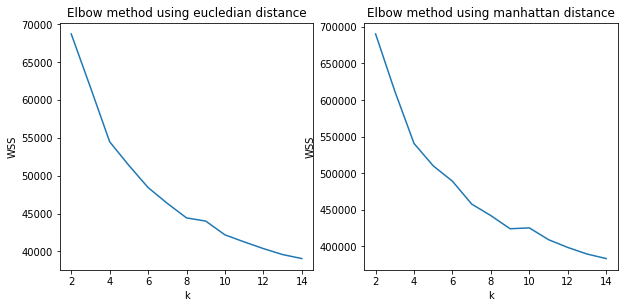

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(ks_kpp,WSS_kpp)
ax2.plot(ks1_kpp,WSS1_kpp)

fig.set_figheight(10)
fig.set_figwidth(10)

ax1.set(xlabel="k",ylabel="WSS")
ax2.set(xlabel="k",ylabel="WSS")

ax1.title.set_text('Elbow method using eucledian distance')
ax2.title.set_text('Elbow method using manhattan distance')
plt.show()

__Observation__ :

- From the first graph we can conclude that the value of k is 8 
- from the second graph we can conclude that k value is 9

We can take any value. Here I'm considering k value as 8

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
k = 8

In [ ]:
np.unique(kmeans_forgy_eucledian_lables)

array([0, 1, 2, 3, 6, 7, 8, 9])

In [ ]:
kmeans = Kmeans(X_train1,y_train1,distance="eucledian")
forgy_centerss = kmeans.forgy(X_train1,k)
kmeans.fit(k,forgy_centerss)
kmeans_forgy_eucledian_lables = kmeans.predict(X_test1)
kmeans_forgy_eucledian_prediction = homogeneity_score(y_test1, kmeans_forgy_eucledian_lables)
print("Homogenity score for forgy, eucledian and testing: ",kmeans_forgy_eucledian_prediction)

kmeans_forgy_eculedian_training_lables = kmeans.predict(X_train1)
kmeans_forgy_eucledian_training_prediction = homogeneity_score(y_train1, kmeans_forgy_eculedian_training_lables)
print("Homogenity score for forgy, eucledian and trainig: ",kmeans_forgy_eucledian_training_prediction)

Homogenity score for forgy, eucledian and testing:  0.4490326923152741
Homogenity score for forgy, eucledian and trainig:  0.45435659173646675


In [ ]:
kmeans = Kmeans(X_train1,y_train1,distance="manhattan")
forgy_centerss = kmeans.forgy(X_train1,k)
kmeans.fit(k,forgy_centerss)
kmeans_forgy_manhattan_lables = kmeans.predict(X_test1)
kmeans_forgy_manhattan_prediction = homogeneity_score(y_test1, kmeans_forgy_manhattan_lables)
print("Homogenity score using manhattan, forgy for tetsing: ",kmeans_forgy_manhattan_prediction)
print("testing accuracy: ",accuracy_score(y_test1,kmeans_forgy_manhattan_lables))
print("f1 score: ",f1_score(y_test, kmeans_forgy_manhattan_lables, zero_division=1, average='micro'))

kmeans_forgy_manhattan_training_lables = kmeans.predict(X_train1)
kmeans_forgy_manhattan_training_prediction = homogeneity_score(y_train1, kmeans_forgy_manhattan_training_lables)
print("Homogenity score using manhattan, forgy for traning: ",kmeans_forgy_manhattan_training_prediction)


Homogenity score using manhattan, forgy for tetsing:  0.4533154870056339
Homogenity score using manhattan, forgy for traning:  0.4569493724036402


In [ ]:
kmeans = Kmeans(X_train1,y_train1,distance="eucledian")
forgy_centerss = kmeans.randomPartition(X_train1,k)
kmeans.fit(k,forgy_centerss)
kmeans_randomPartition_eucledian_lables = kmeans.predict(X_test1)
kmeans_randomPartition_eucledian_prediction = homogeneity_score(y_test1, kmeans_randomPartition_eucledian_lables)
print("testing accuracy: ",accuracy_score(y_test1,kmeans_randomPartition_eucledian_lables))
print("Homogenity score using randompartiotn, eucledian for tetsing: ",kmeans_randomPartition_eucledian_prediction)
print("f1 score: ",f1_score(y_test, kmeans_randomPartition_eucledian_lables, zero_division=1, average='micro'))

kmeans_randomPartition_eculedian_training_lables = kmeans.predict(X_train1)
kmeans_randomPartition_eucledian_training_prediction = homogeneity_score(y_train1, kmeans_randomPartition_eculedian_training_lables)
print("Homogenity score using randompartiotn, eucledian for training: ",kmeans_randomPartition_eucledian_training_prediction)


Homogenity score using randompartiotn, eucledian for tetsing:  0.4489758135681087
Homogenity score using randompartiotn, eucledian for training:  0.45427465150863944


In [ ]:
kmeans = Kmeans(X_train1,y_train1,distance="manhattan")
forgy_centerss = kmeans.randomPartition(X_train1,k)
kmeans.fit(k,forgy_centerss)
kmeans_randomPartition_manhattan_lables = kmeans.predict(X_test1)
kmeans_randomPartition_manhattan_prediction = homogeneity_score(y_test1, kmeans_randomPartition_manhattan_lables)
print("testing accuracy: ",accuracy_score(y_test1,kmeans_randomPartition_manhattan_lables))
print("Homogenity score using randompartiotn, manhattan for tetsing: ",kmeans_randomPartition_manhattan_prediction)
print("f1 score: ",f1_score(y_test, kmeans_randomPartition_manhattan_lables, zero_division=1, average='micro'))


kmeans_randomPartition_manhattan_training_lables = kmeans.predict(X_train1)
kmeans_randomPartition_manhattan_training_prediction = homogeneity_score(y_train1, kmeans_randomPartition_manhattan_training_lables)
print("Homogenity score using randompartiotn, manhattan for training: ",kmeans_randomPartition_manhattan_training_prediction)


Homogenity score using randompartiotn, manhattan for tetsing:  0.4534242721838358
Homogenity score using randompartiotn, manhattan for training:  0.4568717059929578


In [ ]:
import warnings
warnings.filterwarnings('ignore') 

kmeans = Kmeansplusplus(X_train1,y_train1)
centers = kmeans.kmeanspp(X_train1,k)
kmeans.fit(k,centers,dist="eucledian")
kmeans_kpp_eucledian_lables = kmeans.predict(X_test1)
kmeans_kpp_eucledian_prediction = homogeneity_score(y_test1, kmeans_kpp_eucledian_lables)
print("Homogenity score using kpp, eucledian for tetsing: ",kmeans_kpp_eucledian_prediction)
print("testing accuracy: ",accuracy_score(y_test1,kmeans_kpp_eucledian_lables))
print("f1 score: ",f1_score(y_test, kmeans_kpp_eucledian_lables, zero_division=1, average='micro'))

kmeans_kpp_eculedian_training_lables = kmeans.predict(X_train1)
kmeans_kpp_eucledian_training_prediction = homogeneity_score(y_train1, kmeans_kpp_eculedian_training_lables)
print("Homogenity score using kpp, eucledian for training: ",kmeans_kpp_eucledian_training_prediction)


Homogenity score using kpp, eucledian for tetsing:  0.43485070622935146
Homogenity score using kpp, eucledian for training:  0.4399079897773269


In [ ]:
import warnings
warnings.filterwarnings('ignore')  

kmeans = Kmeansplusplus(X_train1,y_train1)
centers = kmeans.kmeanspp(X_train1,k,dist="manhattan")
kmeans.fit(k,centers,dist="manhattan")
kmeans_kpp_manhattan_lables = kmeans.predict(X_test1)
kmeans_kpp_manhattan_prediction = homogeneity_score(y_test1, kmeans_kpp_manhattan_lables)
print("Homogenity score using kpp, kmeans_kpp_manhattan_prediction for testing: ",kmeans_kpp_manhattan_prediction)
print("testing accuracy: ",accuracy_score(y_test1,kmeans_kpp_manhattan_lables))
print("f1 score: ",f1_score(y_test, kmeans_kpp_manhattan_lables, zero_division=1, average='micro'))


kmeans_kpp_manhattan_training_lables = kmeans.predict(X_train1)
kmeans_kpp_manhattan_training_prediction = homogeneity_score(y_train1, kmeans_kpp_manhattan_training_lables)
print("Homogenity score using kpp, manhattan for training: ",kmeans_kpp_manhattan_training_prediction)

Homogenity score using kpp, manhattan for testing:  0.4549808050575254
Homogenity score using kpp, manhattan for training:  0.45725219290364444


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8,n_init=100)
kmeans.fit(X_train1)
kmeans.labels_
l = kmeans.predict(X_test1)
print("Homogenity score for inbuilt matrix is:",homogeneity_score(y_test1, l))
print("testing accuracy: ",accuracy_score(y_test1,l))
print("f1 score: ",f1_score(y_test, l, zero_division=1, average='micro'))

Homogenity score for inbuilt matrix is: 0.4517319677138095


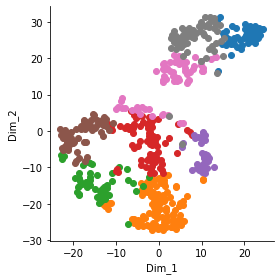

In [ ]:
fun_tsne(kmeans,X_test1,kmeans_kpp_manhattan_lables,500)

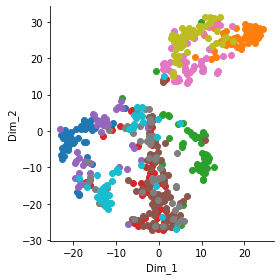

In [ ]:
fun_tsne(kmeans,X_test1,y_test1,500)

__Observation__ :

- From the above we can observe that the outline of the line graph is same
- The clusters are formed properly according to the value of k
- As the value of k is more in original data we can see more clusters in the first figure 

__From these experiments(Part 1 and Part 2), compare accuracy or error, and report which one is better and why?__

- Average homogenity score in part1 is 0.5 where as in part 2 it is 0.45
- But as we observe the lables in part1 is 784 and in latent space repreentation it is only 192
- Comparatively part 2 is faster 
- But the homogenity score is more in part1
- We have to trade-off between speed and accuracy